Maciej Konieczny, 290926

# 1. Samouczek z Internetu
### How to Perform Face Recognition With VGGFace2 in Keras
Link do samouczka: https://machinelearningmastery.com/how-to-perform-face-recognition-with-vggface2-convolutional-neural-network-in-keras/

Ta część pokrywa w całości operacje wykonywane w samouczku i prezentuje otrzymywane wyniki.

### MTCNN

In [1]:
# Załadowanie bibliotek
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from mtcnn import MTCNN

In [2]:
"""
Fragment kodu w tej komórce wymagany był na potrzeby mojego urządzenia z powodu zatrzymywania się jądra Pythona
przy wywoływaniu funkcji imshow z matplotlibu. W przypadku braku problemów ten fragment może zostać pominięty.
"""
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
filename = "sharon_stone1.jpg"

In [4]:
def extract_face(filename, required_size=(224, 224)):
    pixels = plt.imread(filename) # Odczyt pliku
    detector = MTCNN() # Stworzenie modelu
    results = detector.detect_faces(pixels) # Wykrycie twarzy jako box/prostokąt ww którym się znajduje
    x1, y1, width, height = results[0]['box'] #
    x2, y2 = x1 + width, y1 + height          # Wyodrębnienie twarzy jako część obrazu oryginalnego
    face = pixels[y1:y2, x1:x2]               #
    image = Image.fromarray(face)    #
    image = image.resize((224, 224)) # Post-processing do modeli VGGFace2
    face_array = np.asarray(image)   #
    return face_array

In [5]:
pixels = extract_face(filename)

1/1 [==============================] - 0s 298ms/step


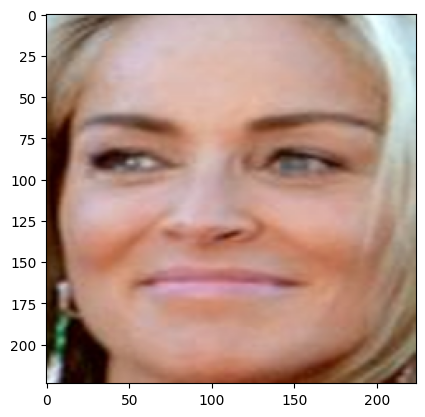

In [6]:
plt.imshow(pixels)
plt.show()

### VGGFace2

In [7]:
# Załadowanie bibliotek
from numpy import expand_dims
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras_vggface.utils import decode_predictions

In [8]:
# Stworzenie modelu
model = VGGFace(model='resnet50')
print('Inputs: %s' % model.inputs)
print('Outputs: %s' % model.outputs)

Inputs: [<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_4')>]
Outputs: [<KerasTensor: shape=(None, 8631) dtype=float32 (created by layer 'classifier')>]


In [9]:
pixels = extract_face("sharon_stone1.jpg") # Przykład jako obraz Sharon Stone
#pixels = extract_face("channing_tatum1.jpg") # Przykład jako obraz Channinga Tatuma

1/1 [==============================] - 1s 680ms/step


In [10]:
# Więcej preprocessingu "wyciętej" twarzy. Przygotowanie do modelu VGGFace2.
pixels = pixels.astype('float32')
samples = expand_dims(pixels, axis=0) # Dodanie wymiaru. Przejście z rozmiaru 224x224x3 do 1x224x224x3
samples = preprocess_input(samples, version=2) # Korekcja wartości pikseli w każdym z kanałów RGB tak, aby wartość średnia pikseli była równa
                                               # wartości średniej pikseli w odpowiadających kanałach obrazów ze zbioru treningowego.
                                               # Cytat: "(...) the pixel values must be centered on each channel using the mean from the training dataset."

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


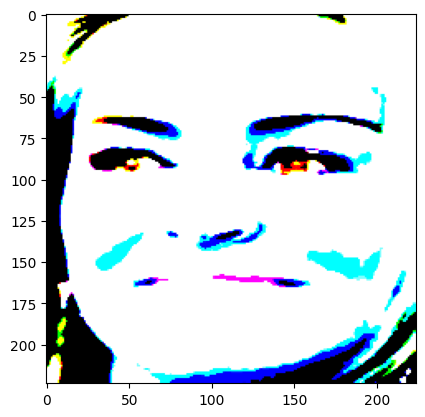

In [11]:
# Podgląd obrazu trafiającego na wejście VGGFace2
plt.imshow(samples[0, :, :, :])
plt.show()

In [12]:
yhat = model.predict(samples) # Klasyfikacja
results = decode_predictions(yhat) # Mapowanie klasyfikacji do nazwisk celebrytów
for result in results[0]:
    print('%s: %.3f%%' % (result[0], result[1]*100))

1/1 [==============================] - 3s 3s/step
b' Sharon_Stone': 99.572%
b' Noelle_Reno': 0.082%
b' Anita_Lipnicka': 0.033%
b' Elisabeth_R\xc3\xb6hm': 0.027%
b' Emma_Atkins': 0.019%


### VGGFace2 bez klasyfikatora

In [13]:
from scipy.spatial.distance import cosine # Obliczanie odległości cosinusowej

In [14]:
# Funkcja dokonująca ekstrakcji twarzy, preprocessingu do modelu VGGFace2 i wykorzystująca model VGGFace2 do identyfikacji twarzy.
def get_embeddings(filenames):
    faces = [extract_face(f) for f in filenames]
    samples = np.asarray(faces, 'float32')
    samples = preprocess_input(samples, version=2)
    model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg') # include_top=False ładuje model bez klasyfikatora.
    yhat = model.predict(samples)
    return yhat

In [15]:
# Funkcja porównująca wektory cech
def is_match(known_embedding, candidate_embedding, thresh=0.5):
    score = cosine(known_embedding, candidate_embedding) # Obliczanie odległości między wektorami cech
    if score <= thresh:
        print('>face is a Match (%.3f <= %.3f)' % (score, thresh))
    else:
        print('>face is NOT a Match (%.3f <= %.3f)' % (score, thresh))

In [16]:
filenames = ['sharon_stone1.jpg', # Zbiór danych
             'sharon_stone2.jpg',
             'sharon_stone3.jpg',
             'channing_tatum1.jpg',
            ]
embeddings = get_embeddings(filenames) # Obliczenie wektora cech dla każdego z obrazów
target = embeddings[0] # Wybranie wektora cech obrazu do identyfikacji
is_match(target, embeddings[1]) #
is_match(target, embeddings[2]) # Porównanie wybranego wektora cech ze wszystkimi w zbiorze
is_match(target, embeddings[3]) #

1/1 [==============================] - 2s 2s/step
>face is a Match (0.461 <= 0.500)
>face is a Match (0.289 <= 0.500)
>face is NOT a Match (0.706 <= 0.500)


In [17]:
# Powyższa komórka powtórzona dla innych pomiarów
"""
filenames = ['rowan_atkinson1.jpg',
             'louis_de_funes2.jpg',
             'jackie_chan3.jpg',
             'channing_tatum2.jpg',
             'rowan_atkinson3.jpg'
            ]
embeddings = get_embeddings(filenames)
target = embeddings[0] # Wybranie wektora cech obrazu do identyfikacji
for i in embeddings:
    is_match(target, i)
"""

"\nfilenames = ['rowan_atkinson1.jpg',\n             'louis_de_funes2.jpg',\n             'jackie_chan3.jpg',\n             'channing_tatum2.jpg',\n             'rowan_atkinson3.jpg'\n            ]\nembeddings = get_embeddings(filenames)\ntarget = embeddings[0] # Wybranie wektora cech obrazu do identyfikacji\nfor i in embeddings:\n    is_match(target, i)\n"

# 2. Dalsze testowanie
### Testy opisane w tej sekcji wykraczają poza zakres samouczka.

In [18]:
import cv2

In [19]:
# Zbiór danych. Lista wszystkich zgromadzonych obrazów.
# WAŻNE! Nie wszystkie z wymienionych osób występują w klasyfikatorze VGGFace2. Poza Sharon Stone i Channingiem Tatumem,
# można sklasyfikować jedynie Dwayne'a Johnsona i Roberta Makłowicza. Pozostałe obrazy można wciąż wykorzystać do weryfikacji.
filenames = ['sharon_stone1.jpg',
             'sharon_stone2.jpg',
             'sharon_stone3.jpg',
             'channing_tatum1.jpg',
             'channing_tatum1_small.jpg',
             'channing_tatum2.jpg',
             'jackie_chan1.jpg',
             'jackie_chan2.jpg',
             'jackie_chan3.jpg',
             'rowan_atkinson1.jpg',
             'rowan_atkinson2.jpg',
             'rowan_atkinson3.jpg',
             'louis_de_funes1.jpg',
             'louis_de_funes2.jpg',
             'jennifer_lopez1.jpg',
             'jennifer_lopez2.jpg',
             'jennifer_lopez3.jpg',
             'jennifer_lopez4.jpg',
             'dwayne_johnson1.jpg',
             'dwayne_johnson2.jpg',
             'dwayne_johnson3.jpg',
             'robert_maklowicz1.jpg',
             'robert_maklowicz2.jpg',
             'robert_maklowicz3.jpg',
             'che_guevara1.jpg'
             ]

1/1 [==============================] - 0s 276ms/step


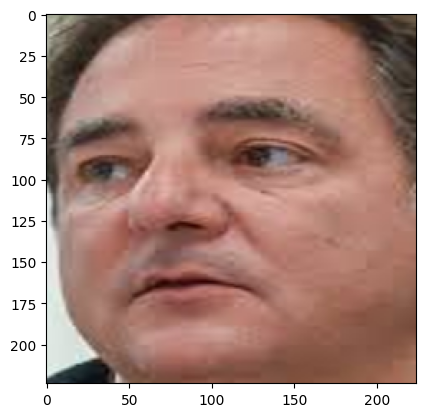

In [20]:
# Wyodrębnienie twarzy z wybranego obrazu
filename = 'robert_maklowicz1.jpg'
image = extract_face(filename)
plt.imshow(image)
plt.show()

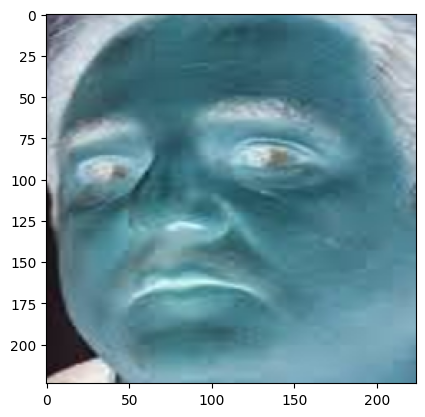

In [21]:
# Wykonanie negatywu obrazu przy użyciu Look-Up Table
lut = np.empty((1,256), np.uint8)
for i in range(256):
    lut[0,i] = 255 - i
image_neg = cv2.LUT(image, lut)
plt.imshow(image_neg)

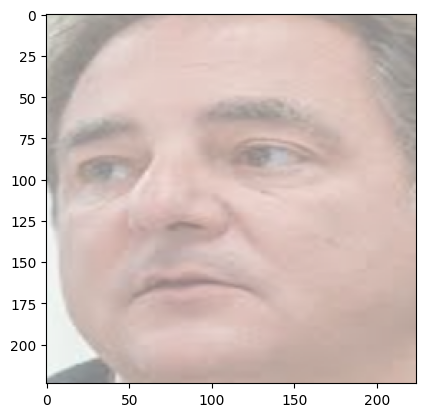

In [22]:
# Pogorszenie kontrastu przez dzielenie wartości pikseli
lut = np.empty((1,256), np.uint8)
for i in range(256):
    lut[0,i] = i*0.5 + 128
image_div = cv2.LUT(image, lut)
plt.imshow(image_div)

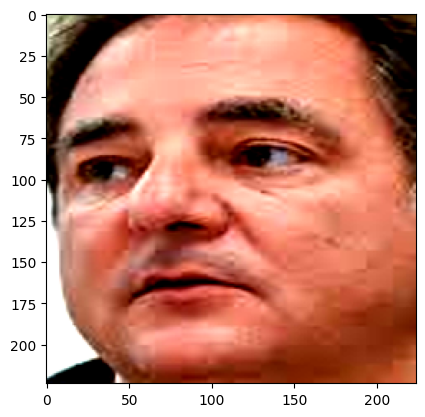

In [23]:
# Poprawienie kontrastu przez mnożenie wartości pikseli
lut = np.empty((1,256), np.uint8)
for i in range(256):
    lut[0,i] = np.clip(i*2 - 128, 0, 255) 
image_mul = cv2.LUT(image, lut)
plt.imshow(image_mul)

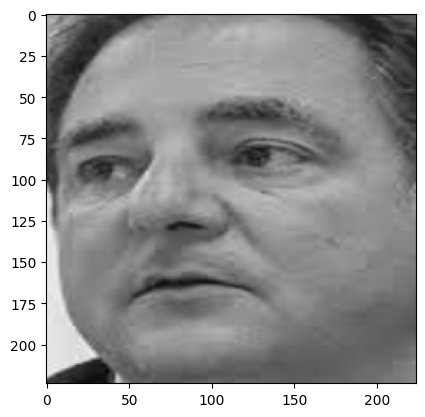

In [24]:
# Przekształcenie obrazu do skali szarości
image_gray = Image.fromarray(image).convert("L")
image_gray = expand_dims(image_gray, axis=2)
image_gray = np.concatenate((image_gray,image_gray,image_gray), axis=2) # Obraz powielany jest do trzech kanałów zawierających te same wartości pikseli.
plt.imshow(image_gray)

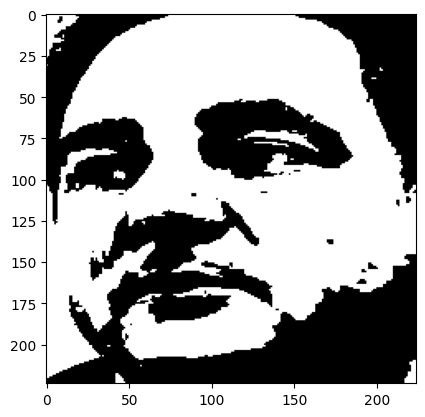

In [25]:
# Binaryzacja obrazu w skali szarości
image_gray1d = Image.fromarray(image).convert("L")
threshold = 127
image_bin = image_gray1d.point(lambda p: 255 if p > threshold else 0) # Dla p > threshold, piksel ustawiany jest na 255, w przeciwnym wypadku na 0.
image_bin = expand_dims(image_bin, axis=2)
image_bin = np.concatenate((image_bin,image_bin,image_bin), axis=2) # Obraz powielany jest do trzech kanałów zawierających te same wartości pikseli.
plt.imshow(image_bin)

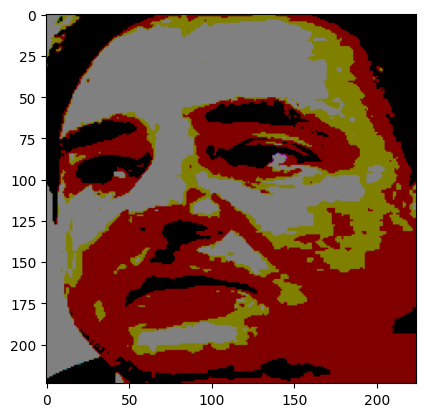

In [26]:
# Obraz zawierający jedynie najistotniejszy bit
image_msb = np.bitwise_and(image,int('10000000',2))
plt.imshow(image_msb)

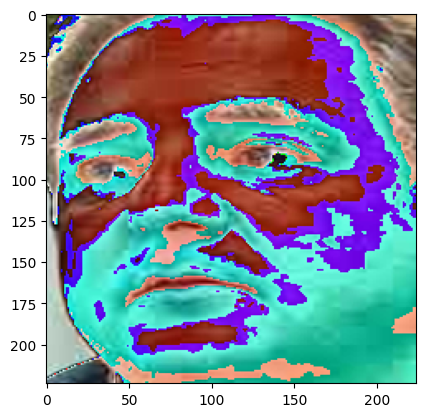

In [27]:
# Obraz zawierający wszystkie bity poza najistotniejszym
image_lsb = np.bitwise_and(image,int('01111111',2))
image_lsb = image_lsb<<1 # Przesunięcie bitów dla rozjaśnienia obrazu
plt.imshow(image_lsb)

In [28]:
# Funkcja wprowadzająca sól i pieprz do obrazu
def salt_and_pepper(input, prob):
    output = input.copy()
    black = np.array([0, 0, 0])
    white = np.array([255, 255, 255])
    probs = np.random.random(output.shape[:2])
    output[probs < (prob/2)] = black
    output[probs > 1 - (prob/2)] = white
    return output

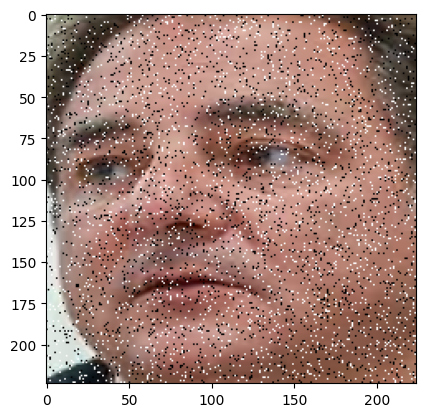

In [29]:
image_salt = salt_and_pepper(image, 0.1) # Zakres od 0 (brak zakłóceń) do 1 (pełne pokrycie)
plt.imshow(image_salt)

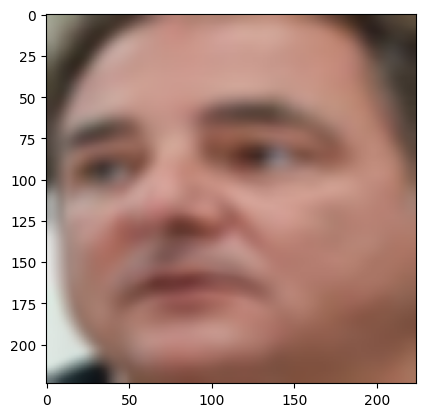

In [30]:
# Obraz z filtrem Gaussowskim
image_Gaussblur = cv2.GaussianBlur(image, (13,13), 6)
plt.imshow(image_Gaussblur)

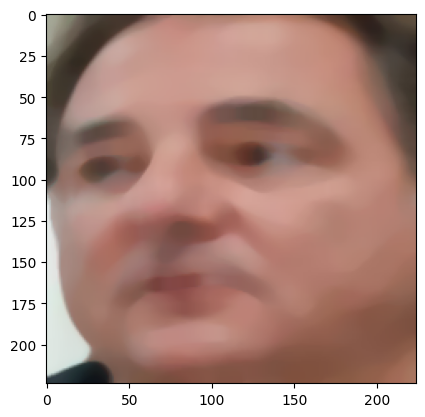

In [31]:
# Obraz z filtrem medianowym
image_medianblur = cv2.medianBlur(image, 15)
plt.imshow(image_medianblur)

In [32]:
# FUnkcja wycinająca fragment obrazu
def cut(input, x1, x2, y1, y2):
    output = input.copy()
    output = output[x1:x2, y1:y2]
    return output

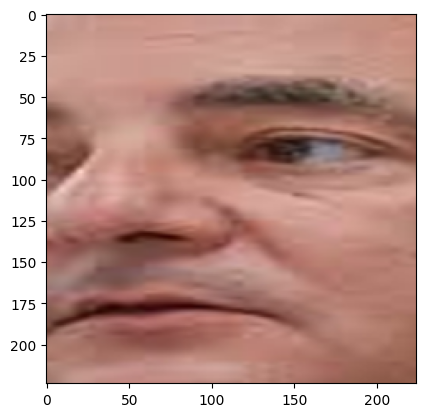

In [33]:
# Obraz fragmentu oryginalnej twarzy
image_cut = cut(image, 20, 200, 50, 170)
image_cut = Image.fromarray(image_cut)
image_cut = image_cut.resize((224,224))
image_cut = np.asarray(image_cut)
plt.imshow(image_cut)

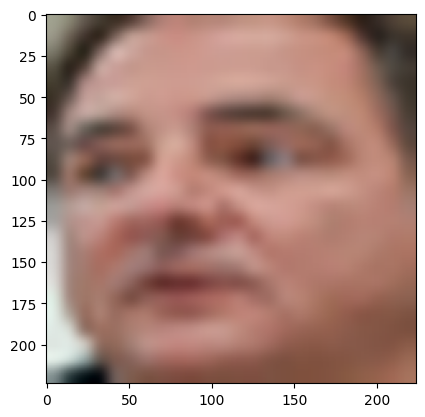

In [34]:
# Obraz przeskalowany
image_resized = Image.fromarray(image)
image_resized = image_resized.resize((24,24)) # Skurczenie obrazu
image_resized = image_resized.resize((224,224)) # Rozciągnięcie obrazu
image_resized = np.asarray(image_resized)
plt.imshow(image_resized)

In [35]:
# Funkcja wygaszająca zielony kanał obrazu
def sub(input):
    output = input.copy()
    output[:,:,1] = np.zeros((224, 224))
    return output

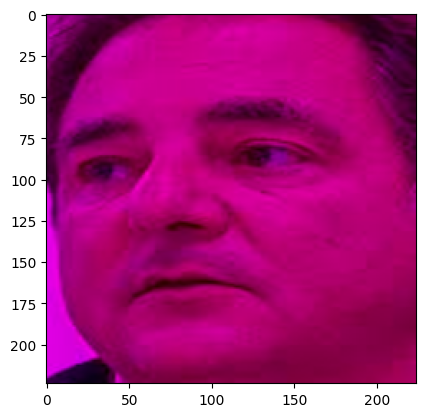

In [36]:
# Obraz z wygaszonym kanałem zielonym
image_2layers = sub(image)
plt.imshow(image_2layers)

In [37]:
# Wektor obrazów twarzy
faces = [image, # twarz domyślna
         image_neg, # negatyw
         image_div, # operacja dzielenia (pogorszenie kontrastu)
         image_mul, # operacja mnożenia (poprawienie kontrastu)
         image_gray, # twarz czarno-biała
         image_bin, # binaryzacja
         image_msb, # najwięcej znaczące bity
         image_lsb, # najmniej znaczące bity
         image_salt, # twarz z zakłóceniem typu sól-pieprz
         image_Gaussblur, # twarz rozmyta filtrem Gaussowskim
         image_medianblur, # twarz rozmyta filtrem medianowym
         image_cut, # obraz dodatkowo przycięty
         image_resized, # obraz ściśnięty i rozciągnięty
         image_2layers # obraz z wygaszoną warstwą zieloną (wartości zieleni każdego pixela = 0)
        ]

# Etykiety
faces_names = ["image",
               "image_neg",
               "image_div",
               "image_mul",
               "image_gray",
               "image_bin",
               "image_msb",
               "image_lsb",
               "image_salt",
               "image_Gaussblur",
               "image_medianblur",
               "image_cut",
               "image_resized",
               "image_2layers"
              ]

In [38]:
# Klasyfikacja każdej twarzy z powyższej listy
count = 0
for face in faces:
    face = face.astype('float32')
    samples = expand_dims(face, axis=0) # Dodanie wymiaru. Przejście z rozmiaru 224x224x3 do 1x224x224x3
    samples = preprocess_input(samples, version=2) # Preprocessing do VGGFace2
    
    model = VGGFace(model='resnet50')
    yhat = model.predict(samples) # Klasyfikacja
    results = decode_predictions(yhat) # Mapowanie klasyfikacji do nazwisk celebrytów
    print(faces_names[count])
    count += 1
    for result in results[0]:
        print('%s: %.3f%%' % (result[0], result[1]*100))

1/1 [==============================] - 2s 2s/step
image
b' Robert_Mak\xc5\x82owicz': 99.573%
b' Gary_Herbert': 0.023%
b' Goldie_Sayers': 0.020%
b' Igor_\xc5\xa0timac': 0.014%
b' Nicola_Cosentino': 0.011%
1/1 [==============================] - 3s 3s/step
image_neg
b' Chali_2na': 2.039%
b' Namadi_Sambo': 1.335%
b' Moussa_Dadis_Camara': 0.948%
b' Al_Jarreau': 0.792%
b' Jackie_Robinson': 0.611%
1/1 [==============================] - 2s 2s/step
image_div
b' Robert_Mak\xc5\x82owicz': 99.781%
b' Vince_Gill': 0.023%
b' Gary_Herbert': 0.010%
b' Tony_Hadley': 0.007%
b' Emeril_Lagasse': 0.006%
1/1 [==============================] - 2s 2s/step
image_mul
b' Robert_Mak\xc5\x82owicz': 99.758%
b' Goldie_Sayers': 0.017%
b' Emeril_Lagasse': 0.015%
b' Igor_\xc5\xa0timac': 0.013%
b' Acun_Il\xc4\xb1cal\xc4\xb1': 0.008%
1/1 [==============================] - 2s 2s/step
image_gray
b' Robert_Mak\xc5\x82owicz': 99.763%
b' Goldie_Sayers': 0.018%
b' Gary_Herbert': 0.014%
b' Nicola_Cosentino': 0.006%
b' Raymond_B

In [39]:
# Funkcja dokonująca preprocessing do modelu VGGFace2 i wykorzystująca model VGGFace2 do identyfikacji twarzy.
def get_embeddings(faces):
    samples = np.asarray(faces, 'float32')
    samples = preprocess_input(samples, version=2) # Dodanie wymiaru. Przejście z rozmiaru 224x224x3 do 1x224x224x3
    model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg') # Preprocessing do VGGFace2
    yhat = model.predict(samples)
    return yhat

In [40]:
# Funkcja porównująca wektory cech (powtórzona)
def is_match(known_embedding, candidate_embedding, thresh=0.5):
    score = cosine(known_embedding, candidate_embedding)
    if score <= thresh:
        print('>face is a Match (%.3f <= %.3f)' % (score, thresh))
    else:
        print('>face is NOT a Match (%.3f <= %.3f)' % (score, thresh))

In [41]:
# Weryfikacja zmodyfikowanych twarzy z oryginalną twarzą
embeddings = get_embeddings(faces)
target = embeddings[0]
count = 0
for i in embeddings:
    print(faces_names[count])
    count += 1
    is_match(target, i)

1/1 [==============================] - 3s 3s/step
image
>face is a Match (0.000 <= 0.500)
image_neg
>face is NOT a Match (0.818 <= 0.500)
image_div
>face is a Match (0.039 <= 0.500)
image_mul
>face is a Match (0.028 <= 0.500)
image_gray
>face is a Match (0.010 <= 0.500)
image_bin
>face is NOT a Match (0.539 <= 0.500)
image_msb
>face is a Match (0.417 <= 0.500)
image_lsb
>face is NOT a Match (0.951 <= 0.500)
image_salt
>face is a Match (0.139 <= 0.500)
image_Gaussblur
>face is a Match (0.089 <= 0.500)
image_medianblur
>face is a Match (0.109 <= 0.500)
image_cut
>face is a Match (0.213 <= 0.500)
image_resized
>face is a Match (0.170 <= 0.500)
image_2layers
>face is a Match (0.106 <= 0.500)


In [42]:
probs = np.random.random(image.shape[:2])

In [43]:
np.shape(probs)

(224, 224)